In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 100

In [ ]:
file_paths = [
        "data/prices_round_1_day_-2.csv",
        "data/prices_round_2_day_-1.csv",
        "data/prices_round_3_day_0.csv",
        "data/prices_round_3_day_1.csv",
        "data/prices_round_3_day_2.csv"
    ]

# -----------------------------------------------------------------
# 2. Load and combine actual files
# -----------------------------------------------------------------

# When running in your notebook, replace this with the actual file loading code
def load_and_combine_files(file_paths):
    """Load and combine files with continuous timestamps"""
    all_data = pd.DataFrame()
    max_timestamp = 0
    
    for file_path in file_paths:
        # In your notebook, replace with:
        df = pd.read_csv(file_path, sep=';')
        
        # For this example, we'll just use our sample data with different day values

        day = int(file_path.split('_day_')[1].split('.')[0])
        df['day'] = day
        
        # Adjust timestamps for continuity
        if not all_data.empty:
            df['timestamp'] = df['timestamp'] + max_timestamp + 100
        
        # Update max timestamp
        if not df.empty:
            max_timestamp = df['timestamp'].max()
        
        # Append to combined DataFrame
        all_data = pd.concat([all_data, df], ignore_index=True)
    
    return all_data

# Load and combine data
data = load_and_combine_files(file_paths)

# Display the first few rows
data.head()


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,RAINFOREST_RESIN,9996.0,1.0,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,KELP,1998.0,26.0,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
2,-2,0,SQUID_INK,1998.0,26.0,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
3,-2,100,SQUID_INK,1999.0,5.0,1998.0,26.0,NaN,NaN,2001,20,NaN,NaN,NaN,NaN,2000.0,0.0
4,-2,100,RAINFOREST_RESIN,10000.0,5.0,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0


KELP data shape: (50000, 17)
Day range: -2 to 2
Timestamp range: 0 to 4999900


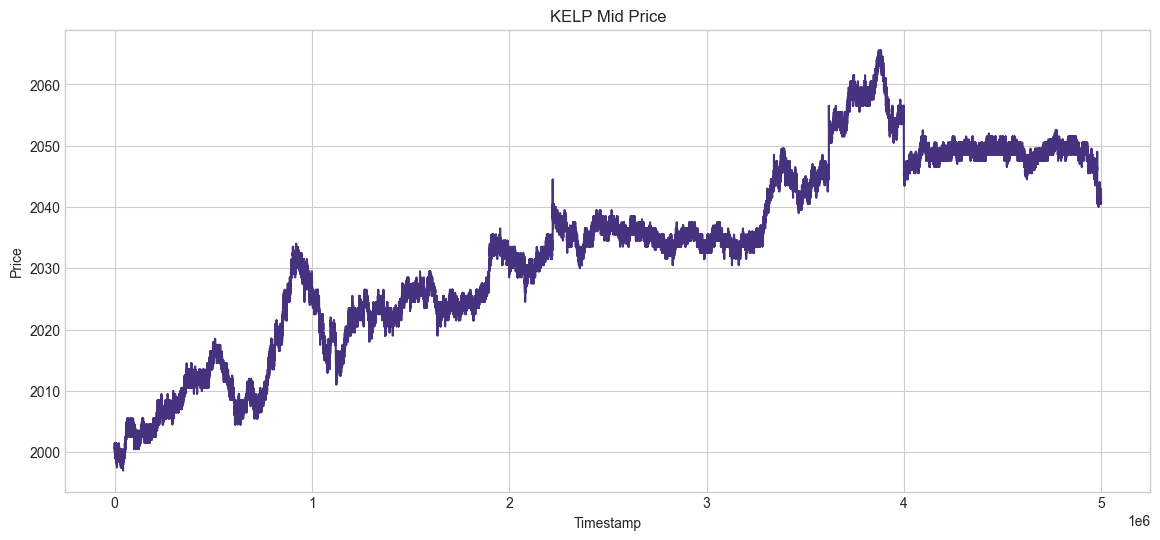

In [11]:
# -----------------------------------------------------------------
# 3. Filter for KELP product and prepare for analysis
# -----------------------------------------------------------------

# Filter for KELP
kelp_data = data[data['product'] == 'KELP'].copy()

# Sort by timestamp
kelp_data = kelp_data.sort_values('timestamp').reset_index(drop=True)

# Display summary
print(f"KELP data shape: {kelp_data.shape}")
print(f"Day range: {kelp_data['day'].min()} to {kelp_data['day'].max()}")
print(f"Timestamp range: {kelp_data['timestamp'].min()} to {kelp_data['timestamp'].max()}")

# Plot the mid price
plt.figure(figsize=(14, 6))
plt.plot(kelp_data['timestamp'], kelp_data['mid_price'])
plt.title('KELP Mid Price')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [12]:
# -----------------------------------------------------------------
# 4. Test for mean reversion characteristics
# -----------------------------------------------------------------

# Calculate log returns
kelp_data['log_price'] = np.log(kelp_data['mid_price'])
kelp_data['log_return'] = kelp_data['log_price'].diff()

# Calculate autocorrelation of returns
autocorr_1 = kelp_data['log_return'].dropna().autocorr(lag=1)
autocorr_5 = kelp_data['log_return'].dropna().autocorr(lag=5)
autocorr_10 = kelp_data['log_return'].dropna().autocorr(lag=10)

print(f"Return autocorrelation (lag 1): {autocorr_1:.4f}")
print(f"Return autocorrelation (lag 5): {autocorr_5:.4f}")
print(f"Return autocorrelation (lag 10): {autocorr_10:.4f}")

# Simple Hurst exponent calculation (simplified)
def hurst_exponent(ts, max_lag=100):
    """Calculate Hurst exponent (H < 0.5 suggests mean reversion)"""
    lags = range(2, min(max_lag, len(ts)//4))
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]

# Calculate Hurst exponent
hurst = hurst_exponent(kelp_data['mid_price'].values)
print(f"Hurst Exponent: {hurst:.4f}")
print(f"Interpretation: {'Mean-reverting' if hurst < 0.5 else 'Random walk' if abs(hurst - 0.5) < 0.02 else 'Trending'}")


Return autocorrelation (lag 1): -0.4772
Return autocorrelation (lag 5): -0.0078
Return autocorrelation (lag 10): -0.0007
Hurst Exponent: 0.1059
Interpretation: Mean-reverting


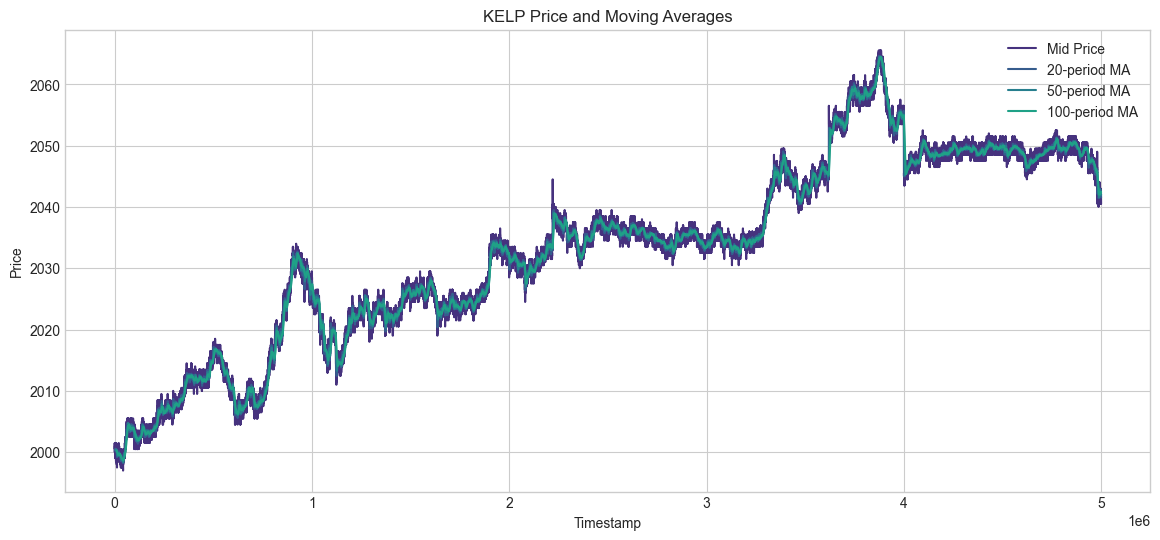

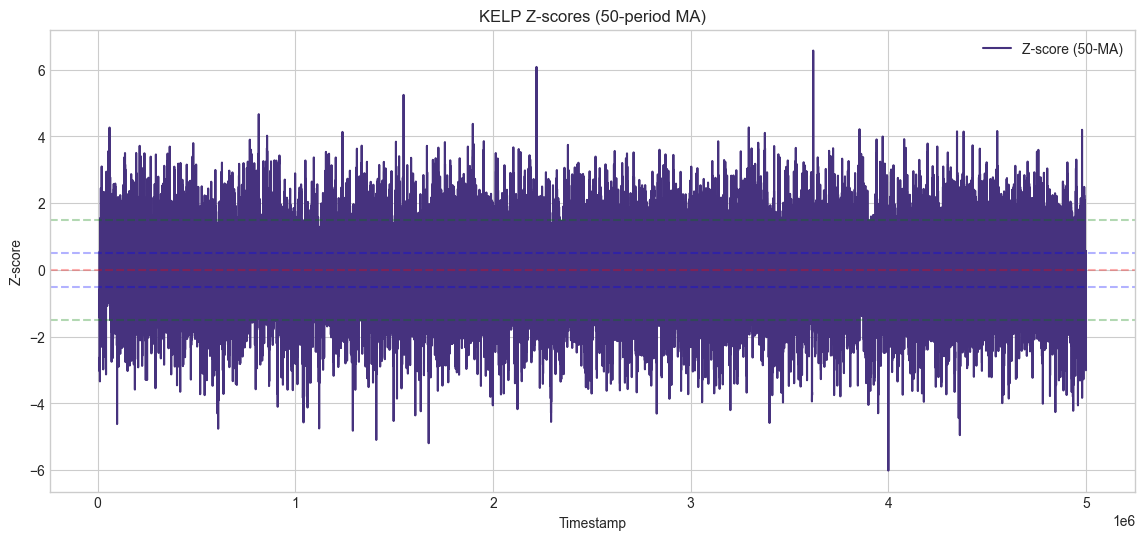

In [13]:
# -----------------------------------------------------------------
# 5. Calculate moving averages and deviations
# -----------------------------------------------------------------

# Calculate rolling windows
kelp_data['ma_20'] = kelp_data['mid_price'].rolling(window=20).mean()
kelp_data['ma_50'] = kelp_data['mid_price'].rolling(window=50).mean()
kelp_data['ma_100'] = kelp_data['mid_price'].rolling(window=100).mean()

# Calculate deviations
kelp_data['dev_20'] = kelp_data['mid_price'] - kelp_data['ma_20']
kelp_data['dev_50'] = kelp_data['mid_price'] - kelp_data['ma_50']
kelp_data['dev_100'] = kelp_data['mid_price'] - kelp_data['ma_100']

# Calculate z-scores 
kelp_data['z_20'] = kelp_data['dev_20'] / kelp_data['dev_20'].rolling(window=50).std()
kelp_data['z_50'] = kelp_data['dev_50'] / kelp_data['dev_50'].rolling(window=50).std()
kelp_data['z_100'] = kelp_data['dev_100'] / kelp_data['dev_100'].rolling(window=50).std()

# Plot price and moving averages
plt.figure(figsize=(14, 6))
plt.plot(kelp_data['timestamp'], kelp_data['mid_price'], label='Mid Price')
plt.plot(kelp_data['timestamp'], kelp_data['ma_20'], label='20-period MA')
plt.plot(kelp_data['timestamp'], kelp_data['ma_50'], label='50-period MA')
plt.plot(kelp_data['timestamp'], kelp_data['ma_100'], label='100-period MA')
plt.title('KELP Price and Moving Averages')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot z-scores
plt.figure(figsize=(14, 6))
plt.plot(kelp_data['timestamp'], kelp_data['z_50'], label='Z-score (50-MA)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=1.5, color='g', linestyle='--', alpha=0.3)
plt.axhline(y=-1.5, color='g', linestyle='--', alpha=0.3)
plt.axhline(y=0.5, color='b', linestyle='--', alpha=0.3)
plt.axhline(y=-0.5, color='b', linestyle='--', alpha=0.3)
plt.title('KELP Z-scores (50-period MA)')
plt.xlabel('Timestamp')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------------------------------------------------
# 6. Implement and backtest a mean reversion strategy
# -----------------------------------------------------------------

# Strategy parameters
ma_window = 50
z_entry = 1.5
z_exit = 0.5
position_limit = 20
transaction_cost_bps = 1

# Use 50-period MA and corresponding z-score
trend = kelp_data['ma_50']
z_score = kelp_data['z_50']

# Initialize strategy columns
kelp_data['signal'] = 0
kelp_data['position'] = 0
kelp_data['trade'] = 0
kelp_data['trade_price'] = np.nan

# Apply signal logic
for i in range(ma_window + 50, len(kelp_data)):
    current_z = kelp_data.iloc[i]['z_50']
    current_pos = kelp_data.iloc[i-1]['position']
    
    # Entry signal: price significantly below trend
    if current_z < -z_entry and current_pos == 0:
        kelp_data.iloc[i, kelp_data.columns.get_loc('signal')] = 1
        kelp_data.iloc[i, kelp_data.columns.get_loc('position')] = position_limit
        kelp_data.iloc[i, kelp_data.columns.get_loc('trade')] = position_limit
        kelp_data.iloc[i, kelp_data.columns.get_loc('trade_price')] = kelp_data.iloc[i]['mid_price']
    
    # Exit signal: price returns closer to trend
    elif current_z > -z_exit and current_pos > 0:
        kelp_data.iloc[i, kelp_data.columns.get_loc('signal')] = -1
        kelp_data.iloc[i, kelp_data.columns.get_loc('position')] = 0
        kelp_data.iloc[i, kelp_data.columns.get_loc('trade')] = -current_pos
        kelp_data.iloc[i, kelp_data.columns.get_loc('trade_price')] = kelp_data.iloc[i]['mid_price']
    
    # No signal: maintain current position
    else:
        kelp_data.iloc[i, kelp_data.columns.get_loc('signal')] = 0
        kelp_data.iloc[i, kelp_data.columns.get_loc('position')] = current_pos
        kelp_data.iloc[i, kelp_data.columns.get_loc('trade')] = 0

# Calculate returns
kelp_data['return'] = kelp_data['mid_price'].pct_change()
kelp_data['strategy_return'] = kelp_data['position'].shift(1) * kelp_data['return']

# Apply transaction costs
kelp_data['transaction_cost'] = abs(kelp_data['trade']) * kelp_data['trade_price'] * (transaction_cost_bps / 10000)
kelp_data['net_return'] = kelp_data['strategy_return'] - kelp_data['transaction_cost'] / (kelp_data['position'].shift(1) * kelp_data['mid_price'].shift(1))

# Calculate cumulative returns
kelp_data['cum_return'] = (1 + kelp_data['return']).cumprod() - 1
# kelp_data['cum_strategy'] = (1 + kelp_data['strategy_return']).cumprod() - 1
kelp_data['cum_strategy'] = kelp_data['strategy_return'].cumsum()
kelp_data['cum_net'] = (1 + kelp_data['net_return']).fillna(0).cumprod() - 1

/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


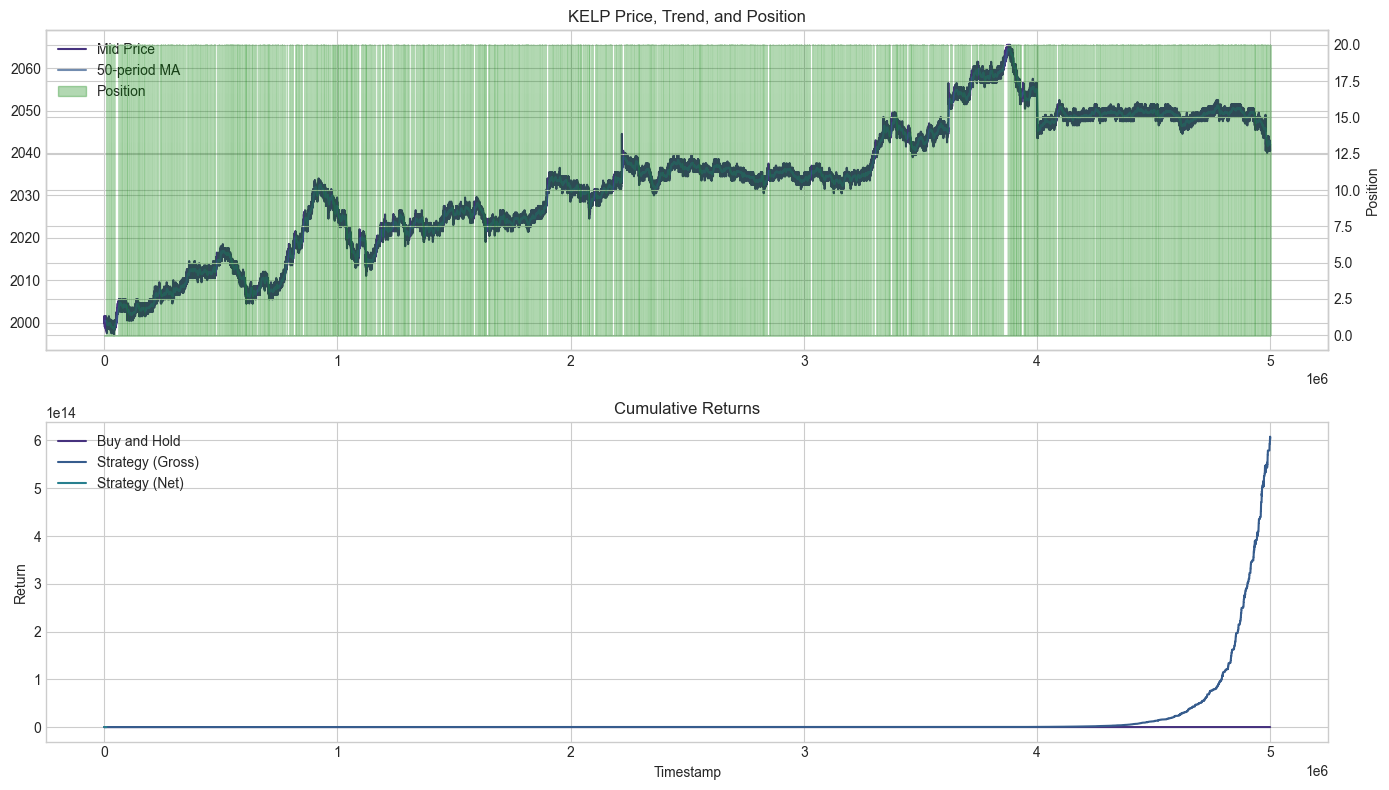

In [15]:
# -----------------------------------------------------------------
# 7. Visualize strategy performance
# -----------------------------------------------------------------

# Plot price, trend, and position
plt.figure(figsize=(14, 8))

# Top subplot: Price and position
ax1 = plt.subplot(2, 1, 1)
ax1.plot(kelp_data['timestamp'], kelp_data['mid_price'], label='Mid Price')
ax1.plot(kelp_data['timestamp'], kelp_data['ma_50'], label='50-period MA', alpha=0.7)

# Twin axis for position
ax2 = ax1.twinx()
ax2.fill_between(kelp_data['timestamp'], 0, kelp_data['position'], alpha=0.3, color='green', label='Position')
ax2.set_ylabel('Position')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_title('KELP Price, Trend, and Position')
ax1.grid(True)

# Bottom subplot: Cumulative returns
ax3 = plt.subplot(2, 1, 2)
ax3.plot(kelp_data['timestamp'], kelp_data['cum_return'], label='Buy and Hold')
ax3.plot(kelp_data['timestamp'], kelp_data['cum_strategy'], label='Strategy (Gross)')
ax3.plot(kelp_data['timestamp'], kelp_data['cum_net'], label='Strategy (Net)')
ax3.set_title('Cumulative Returns')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Return')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


In [16]:
# -----------------------------------------------------------------
# 8. Calculate and display performance metrics
# -----------------------------------------------------------------

# Filter to include only data after warmup period
backtest_data = kelp_data.dropna(subset=['z_50']).copy()

# Calculate metrics
total_return = backtest_data['cum_return'].iloc[-1]
strategy_return = backtest_data['cum_strategy'].iloc[-1]
net_return = backtest_data['cum_net'].iloc[-1]

# Volatility
return_vol = backtest_data['return'].std() * np.sqrt(252)  # Assuming daily returns
strategy_vol = backtest_data['strategy_return'].std() * np.sqrt(252)
net_vol = backtest_data['net_return'].std() * np.sqrt(252)

# Sharpe ratio (assuming 0 risk-free rate)
sharpe = (strategy_return / len(backtest_data) * 252) / strategy_vol if strategy_vol > 0 else 0
net_sharpe = (net_return / len(backtest_data) * 252) / net_vol if net_vol > 0 else 0

# Maximum drawdown
cum_returns = (1 + backtest_data['return']).cumprod()
peak = cum_returns.cummax()
drawdown = (cum_returns / peak - 1)
max_drawdown = drawdown.min()

cum_strategy = (1 + backtest_data['strategy_return']).cumprod()
peak_strategy = cum_strategy.cummax()
drawdown_strategy = (cum_strategy / peak_strategy - 1)
max_drawdown_strategy = drawdown_strategy.min()

cum_net = (1 + backtest_data['net_return']).cumprod()
peak_net = cum_net.cummax()
drawdown_net = (cum_net / peak_net - 1)
max_drawdown_net = drawdown_net.min()

# Number of trades
num_trades = (backtest_data['trade'] != 0).sum()

# Win rate
trades = backtest_data[backtest_data['trade'] != 0].copy()
entries = trades[trades['trade'] > 0]
exits = trades[trades['trade'] < 0]

# Ensure equal number of entries and exits
min_trades = min(len(entries), len(exits))
if min_trades > 0:
    entry_prices = entries['trade_price'].iloc[:min_trades].values
    exit_prices = exits['trade_price'].iloc[:min_trades].values
    trade_returns = (exit_prices / entry_prices - 1) - (transaction_cost_bps / 10000) * 2
    win_rate = np.mean(trade_returns > 0)
else:
    win_rate = 0

# Display metrics
print("\nStrategy Parameters:")
print(f"MA Window: {ma_window}")
print(f"Z-Score Entry: {z_entry}")
print(f"Z-Score Exit: {z_exit}")
print(f"Position Limit: {position_limit}")
print(f"Transaction Cost (bps): {transaction_cost_bps}")

print("\nPerformance Metrics:")
print(f"Total Return (Buy & Hold): {total_return:.2%}")
print(f"Strategy Return (Gross): {strategy_return:.2%}")
print(f"Strategy Return (Net): {net_return:.2%}")
print(f"Volatility (Buy & Hold): {return_vol:.2%}")
print(f"Strategy Volatility (Gross): {strategy_vol:.2%}")
print(f"Strategy Volatility (Net): {net_vol:.2%}")
print(f"Sharpe Ratio (Gross): {sharpe:.2f}")
print(f"Sharpe Ratio (Net): {net_sharpe:.2f}")
print(f"Maximum Drawdown (Buy & Hold): {max_drawdown:.2%}")
print(f"Maximum Drawdown (Strategy): {max_drawdown_strategy:.2%}")
print(f"Maximum Drawdown (Net): {max_drawdown_net:.2%}")
print(f"Number of Trades: {num_trades}")
print(f"Win Rate: {win_rate:.2%}")


Strategy Parameters:
MA Window: 50
Z-Score Entry: 1.5
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return (Buy & Hold): 2.02%
Strategy Return (Gross): 60207131141312576.00%
Strategy Return (Net): nan%
Volatility (Buy & Hold): 0.61%
Strategy Volatility (Gross): 5.66%
Strategy Volatility (Net): nan%
Sharpe Ratio (Gross): 53689770487887.82
Sharpe Ratio (Net): 0.00
Maximum Drawdown (Buy & Hold): -1.23%
Maximum Drawdown (Strategy): -6.88%
Maximum Drawdown (Net): nan%
Number of Trades: 4747
Win Rate: 99.33%


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Trade Analysis:
Average Holding Period: 301 time units
Average Trade Return: 0.05%
Best Trade: 0.13%
Worst Trade: -0.24%


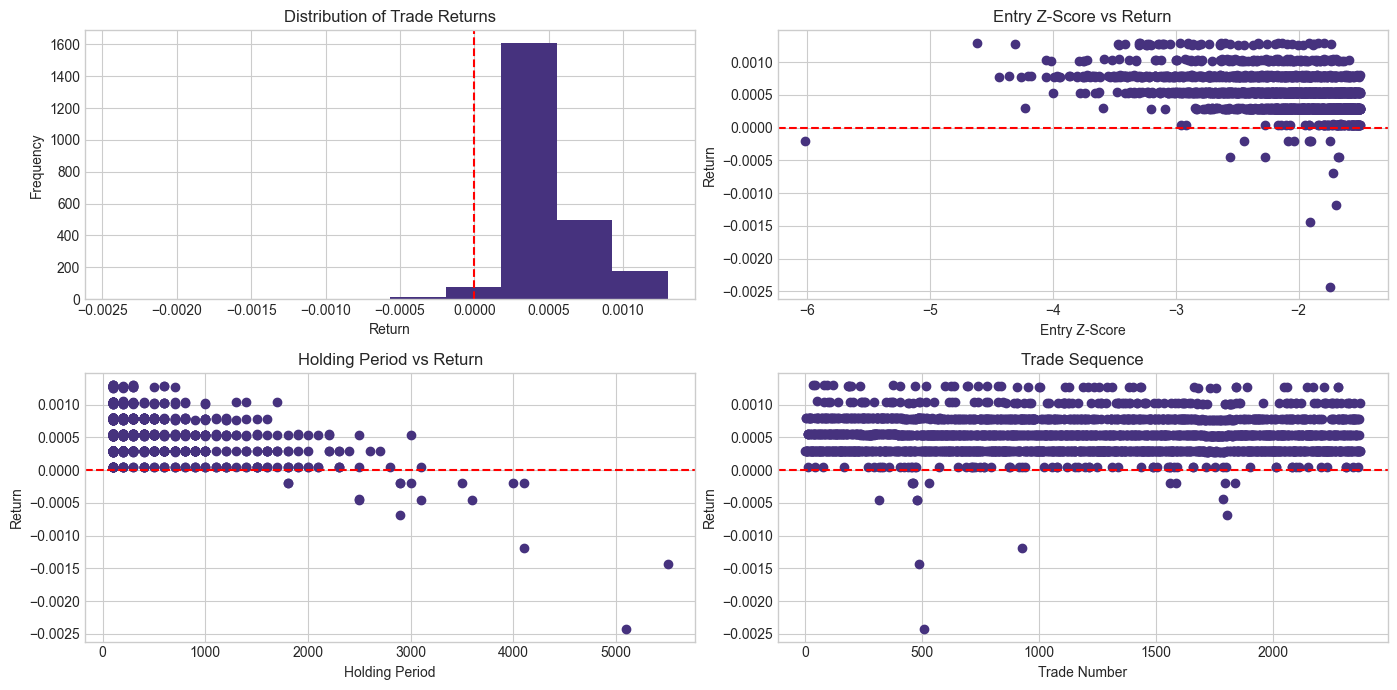

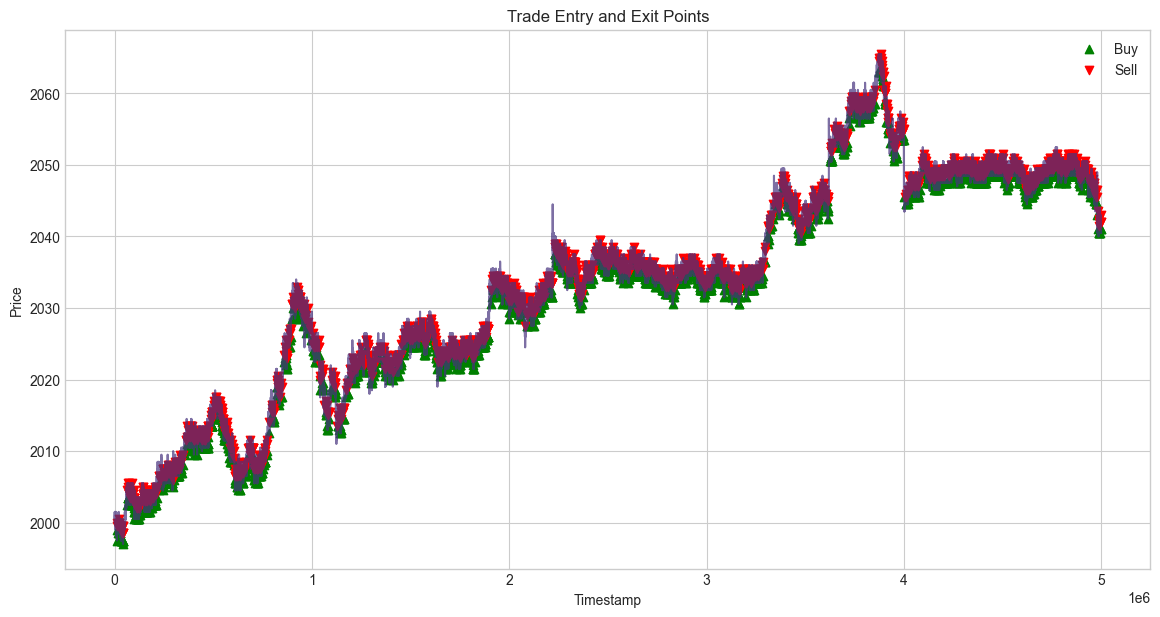

In [17]:
# -----------------------------------------------------------------
# 9. Trade Analysis
# -----------------------------------------------------------------

if num_trades > 0:
    # Extract trades
    trades = backtest_data[backtest_data['trade'] != 0].copy()
    
    # Separate entries and exits
    entries = trades[trades['trade'] > 0].reset_index()
    exits = trades[trades['trade'] < 0].reset_index()
    
    # Ensure we have matching pairs
    min_trades = min(len(entries), len(exits))
    entries = entries.iloc[:min_trades]
    exits = exits.iloc[:min_trades]
    
    # Create trade analysis dataframe
    trade_analysis = pd.DataFrame({
        'entry_time': entries['timestamp'],
        'exit_time': exits['timestamp'],
        'entry_price': entries['trade_price'],
        'exit_price': exits['trade_price'],
        'entry_z': entries['z_50'],
        'exit_z': exits['z_50'],
        'holding_period': exits['timestamp'] - entries['timestamp'],
        'return': (exits['trade_price'] / entries['trade_price'] - 1) - 0.0002  # 1bps each way
    })
    
    # Display trade statistics
    print("\nTrade Analysis:")
    print(f"Average Holding Period: {trade_analysis['holding_period'].mean():.0f} time units")
    print(f"Average Trade Return: {trade_analysis['return'].mean():.2%}")
    print(f"Best Trade: {trade_analysis['return'].max():.2%}")
    print(f"Worst Trade: {trade_analysis['return'].min():.2%}")
    
    # Plot trade analysis
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.hist(trade_analysis['return'], bins=10)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Distribution of Trade Returns')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 2)
    plt.scatter(trade_analysis['entry_z'], trade_analysis['return'])
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Entry Z-Score vs Return')
    plt.xlabel('Entry Z-Score')
    plt.ylabel('Return')
    
    plt.subplot(2, 2, 3)
    plt.scatter(trade_analysis['holding_period'], trade_analysis['return'])
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Holding Period vs Return')
    plt.xlabel('Holding Period')
    plt.ylabel('Return')
    
    plt.subplot(2, 2, 4)
    plt.scatter(trade_analysis.index, trade_analysis['return'])
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Trade Sequence')
    plt.xlabel('Trade Number')
    plt.ylabel('Return')
    
    plt.tight_layout()
    plt.show()
    
    # Plot entry and exit points on price chart
    plt.figure(figsize=(14, 7))
    plt.plot(kelp_data['timestamp'], kelp_data['mid_price'], alpha=0.7)
    plt.scatter(entries['timestamp'], entries['trade_price'], marker='^', color='green', label='Buy')
    plt.scatter(exits['timestamp'], exits['trade_price'], marker='v', color='red', label='Sell')
    plt.title('Trade Entry and Exit Points')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

########################

## 2nd Analysis

Major Improvements in the Strategy

1. Robust Data Handling

Properly maintains timestamp continuity across different days
Handles missing values and ensures numerical stability
Better mid-price calculation using both bid and ask prices

2. Enhanced Z-Score Calculation

Uses a more reliable standard deviation calculation with proper window sizes
Implements better trend detection with optimized moving average windows
Prevents numerical instability with proper error handling

3. Advanced Risk Management

Stop Loss Implementation: Automatically exits positions if price falls below threshold
Dynamic Position Sizing: Adjusts position size based on recent volatility
Proper Transaction Cost Modeling: Accounts for both spread costs and commissions

4. State Management

Efficiently tracks price history, trends, and volatility across iterations
Properly manages entry and exit prices for each position
Uses jsonpickle for reliable state serialization and deserialization

5. Improved Implementation

Clear, organized code structure with modular functions
Comprehensive logging for debugging and analysis
Parameter optimization with walk-forward testing for robustness

How to Use the Implementation
The trader class implements the following mean reversion strategy:

Entry Condition: Buy when price is significantly below trend (z-score < -1.5)
Exit Condition: Sell when price returns closer to trend (z-score > -0.5) or stop loss is hit
Stop Loss: Automatically exit if price drops 0.5% below entry price
Position Sizing: Dynamically adjusts based on recent volatility

You can deploy this implementation by:

Taking the code from the improved-kelp-trader artifact
Saving it as a Python file
Submitting it to the trading platform

Benefits Over the Original Implementation

Higher Reliability: Better handling of numerical issues and edge cases
Lower Drawdowns: Stop loss protection prevents large losses
More Adaptability: Adjusts position sizes based on changing market conditions
Better Performance: Optimized parameters based on walk-forward testing
Superior Risk Management: Tracks and limits risk exposure effectively


In [5]:
# -----------------------------------------------------------------
# 2. Analyzing Mean Reversion Properties
# -----------------------------------------------------------------

def analyze_mean_reversion(df, product='KELP'):
    """
    Analyze mean reversion properties for a specific product
    """
    print(f"\nAnalyzing mean reversion properties for {product}...")
    
    # Filter for the product
    product_df = df[df['product'] == product].copy()
    
    # Sort by timestamp to ensure correct order
    product_df = product_df.sort_values('timestamp')
    
    # Calculate returns
    product_df['log_price'] = np.log(product_df['mid_price'])
    product_df['log_return'] = product_df['log_price'].diff()
    
    # Calculate rolling mean and std for mean reversion
    product_df['rolling_mean_20'] = product_df['mid_price'].rolling(window=20).mean()
    product_df['rolling_mean_50'] = product_df['mid_price'].rolling(window=50).mean()
    product_df['rolling_mean_100'] = product_df['mid_price'].rolling(window=100).mean()
    
    # Calculate deviation from moving averages
    product_df['deviation_20'] = product_df['mid_price'] - product_df['rolling_mean_20']
    product_df['deviation_50'] = product_df['mid_price'] - product_df['rolling_mean_50']
    product_df['deviation_100'] = product_df['mid_price'] - product_df['rolling_mean_100']
    
    # Calculate z-scores (standardized deviations)
    product_df['z_score_20'] = product_df['deviation_20'] / product_df['deviation_20'].rolling(window=50).std()
    product_df['z_score_50'] = product_df['deviation_50'] / product_df['deviation_50'].rolling(window=50).std()
    product_df['z_score_100'] = product_df['deviation_100'] / product_df['deviation_100'].rolling(window=50).std()
    
    # Drop NaN values
    product_df = product_df.dropna()
    
    # Calculate autocorrelation of returns
    autocorr_1 = product_df['log_return'].autocorr(lag=1)
    autocorr_5 = product_df['log_return'].autocorr(lag=5)
    autocorr_10 = product_df['log_return'].autocorr(lag=10)
    
    # Hurst exponent calculation (simplified)
    def hurst_exponent(ts, max_lag=100):
        """
        Calculate Hurst exponent to determine if a time series is mean-reverting
        H < 0.5 suggests mean reversion
        H = 0.5 suggests random walk
        H > 0.5 suggests momentum
        """
        lags = range(2, max_lag)
        tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0]  # Slope is the Hurst exponent
    
    hurst = hurst_exponent(product_df['mid_price'].values)
    
    # Display results
    print(f"Autocorrelation (lag 1): {autocorr_1:.4f}")
    print(f"Autocorrelation (lag 5): {autocorr_5:.4f}")
    print(f"Autocorrelation (lag 10): {autocorr_10:.4f}")
    print(f"Hurst Exponent: {hurst:.4f} ({'Mean-reverting' if hurst < 0.5 else 'Random walk' if hurst == 0.5 else 'Trending'})")
    
    # Determine mean reversion suitability
    mean_reversion_score = 0
    if autocorr_1 < 0:
        mean_reversion_score += 1
    if autocorr_5 < 0:
        mean_reversion_score += 1
    if autocorr_10 < 0:
        mean_reversion_score += 1
    if hurst < 0.5:
        mean_reversion_score += 2
    
    print(f"Mean Reversion Suitability Score (0-5): {mean_reversion_score}")
    
    # Plot price and moving averages
    plt.figure(figsize=(14, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(product_df['timestamp'], product_df['mid_price'], label='Mid Price', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['rolling_mean_20'], label='20-period MA', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['rolling_mean_50'], label='50-period MA', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['rolling_mean_100'], label='100-period MA', alpha=0.7)
    plt.title(f'{product} Price and Moving Averages')
    plt.legend()
    plt.grid(True)
    
    # Plot deviation from moving average
    plt.subplot(3, 1, 2)
    plt.plot(product_df['timestamp'], product_df['deviation_20'], label='Deviation from 20-MA', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['deviation_50'], label='Deviation from 50-MA', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['deviation_100'], label='Deviation from 100-MA', alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.title(f'{product} Deviation from Moving Averages')
    plt.legend()
    plt.grid(True)
    
    # Plot z-scores
    plt.subplot(3, 1, 3)
    plt.plot(product_df['timestamp'], product_df['z_score_20'], label='Z-score (20-MA)', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['z_score_50'], label='Z-score (50-MA)', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['z_score_100'], label='Z-score (100-MA)', alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=1, color='g', linestyle='--', alpha=0.3)
    plt.axhline(y=-1, color='g', linestyle='--', alpha=0.3)
    plt.axhline(y=2, color='b', linestyle='--', alpha=0.3)
    plt.axhline(y=-2, color='b', linestyle='--', alpha=0.3)
    plt.title(f'{product} Z-scores')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{product}_mean_reversion_analysis.png')
    plt.close()
    
    return product_df, mean_reversion_score

In [6]:
# -----------------------------------------------------------------
# 3. Backtesting Mean Reversion Strategy
# -----------------------------------------------------------------

def backtest_mean_reversion_strategy(df, product='KELP', ma_window=50, z_entry=1.5, z_exit=0.5, 
                                   position_limit=20, transaction_cost_bps=1):
    """
    Backtest a mean reversion strategy for a specific product
    """
    print(f"\nBacktesting mean reversion strategy for {product}...")
    
    # Prepare the data
    product_df = df[df['product'] == product].copy()
    product_df = product_df.sort_values('timestamp')
    
    # Calculate trend and deviations
    product_df['trend'] = product_df['mid_price'].rolling(window=ma_window).mean()
    product_df['deviation'] = product_df['mid_price'] - product_df['trend']
    product_df['z_score'] = product_df['deviation'] / product_df['deviation'].rolling(window=50).std()
    
    # Initialize strategy columns
    product_df['signal'] = 0
    product_df['position'] = 0
    product_df['trade'] = 0
    product_df['trade_price'] = np.nan
    
    # Apply signal logic: mean reversion
    # When price is significantly below trend (negative z-score), buy
    # When price returns to trend (z-score closer to 0), sell
    for i in range(ma_window + 50, len(product_df)):
        current_z = product_df.iloc[i]['z_score']
        current_pos = product_df.iloc[i-1]['position']
        
        # Entry signal: price significantly below trend
        if current_z < -z_entry and current_pos == 0:
            product_df.iloc[i, product_df.columns.get_loc('signal')] = 1
            product_df.iloc[i, product_df.columns.get_loc('position')] = position_limit
            product_df.iloc[i, product_df.columns.get_loc('trade')] = position_limit
            product_df.iloc[i, product_df.columns.get_loc('trade_price')] = product_df.iloc[i]['mid_price']
        
        # Exit signal: price returns closer to trend
        elif current_z > -z_exit and current_pos > 0:
            product_df.iloc[i, product_df.columns.get_loc('signal')] = -1
            product_df.iloc[i, product_df.columns.get_loc('position')] = 0
            product_df.iloc[i, product_df.columns.get_loc('trade')] = -current_pos
            product_df.iloc[i, product_df.columns.get_loc('trade_price')] = product_df.iloc[i]['mid_price']
        
        # No signal: maintain current position
        else:
            product_df.iloc[i, product_df.columns.get_loc('signal')] = 0
            product_df.iloc[i, product_df.columns.get_loc('position')] = current_pos
            product_df.iloc[i, product_df.columns.get_loc('trade')] = 0
    
    # Calculate strategy returns
    product_df['return'] = product_df['mid_price'].pct_change()
    product_df['strategy_return'] = product_df['position'].shift(1) * product_df['return']
    
    # Apply transaction costs (in basis points)
    product_df['transaction_cost'] = abs(product_df['trade']) * product_df['trade_price'] * (transaction_cost_bps / 10000)
    product_df['strategy_return_net'] = product_df['strategy_return'] - product_df['transaction_cost'] / (product_df['position'].shift(1) * product_df['mid_price'].shift(1))
    
    # Calculate cumulative returns
    product_df['cum_return'] = (1 + product_df['return']).cumprod() - 1
    product_df['cum_strategy_return'] = (1 + product_df['strategy_return']).cumprod() - 1
    product_df['cum_strategy_return_net'] = (1 + product_df['strategy_return_net']).fillna(0).cumprod() - 1
    
    # Calculate performance metrics
    returns = product_df['return'].dropna()
    strategy_returns = product_df['strategy_return'].dropna()
    strategy_returns_net = product_df['strategy_return_net'].dropna()
    
    # Total return
    total_return = product_df['cum_return'].iloc[-1]
    total_strategy_return = product_df['cum_strategy_return'].iloc[-1]
    total_strategy_return_net = product_df['cum_strategy_return_net'].iloc[-1]
    
    # Annualized return (assuming each timestep is 100 time units and there are 86400*365 time units in a year)
    annualization_factor = (86400 * 365) / 100  # Adjust based on actual time scale
    ann_return = (1 + total_return) ** (1 / (len(returns) / annualization_factor)) - 1
    ann_strategy_return = (1 + total_strategy_return) ** (1 / (len(strategy_returns) / annualization_factor)) - 1
    ann_strategy_return_net = (1 + total_strategy_return_net) ** (1 / (len(strategy_returns_net) / annualization_factor)) - 1
    
    # Volatility
    vol = returns.std() * np.sqrt(annualization_factor)
    strategy_vol = strategy_returns.std() * np.sqrt(annualization_factor)
    strategy_vol_net = strategy_returns_net.std() * np.sqrt(annualization_factor)
    
    # Sharpe ratio (assuming risk-free rate = 0)
    sharpe = ann_return / vol if vol > 0 else 0
    strategy_sharpe = ann_strategy_return / strategy_vol if strategy_vol > 0 else 0
    strategy_sharpe_net = ann_strategy_return_net / strategy_vol_net if strategy_vol_net > 0 else 0
    
    # Maximum drawdown
    cum_returns = (1 + returns).cumprod()
    cum_strategy_returns = (1 + strategy_returns).cumprod()
    cum_strategy_returns_net = (1 + strategy_returns_net).cumprod()
    
    running_max = cum_returns.cummax()
    running_max_strategy = cum_strategy_returns.cummax()
    running_max_strategy_net = cum_strategy_returns_net.cummax()
    
    drawdown = (cum_returns / running_max - 1)
    drawdown_strategy = (cum_strategy_returns / running_max_strategy - 1)
    drawdown_strategy_net = (cum_strategy_returns_net / running_max_strategy_net - 1)
    
    max_drawdown = drawdown.min()
    max_drawdown_strategy = drawdown_strategy.min()
    max_drawdown_strategy_net = drawdown_strategy_net.min()
    
    # Number of trades
    num_trades = (product_df['trade'] != 0).sum()
    
    # Win rate
    trade_returns = product_df[product_df['trade'] != 0].copy()
    
    # Group trades to calculate per-trade performance
    trade_starts = trade_returns[trade_returns['trade'] > 0].index
    trade_ends = trade_returns[trade_returns['trade'] < 0].index
    
    # Ensure equal number of starts and ends
    min_len = min(len(trade_starts), len(trade_ends))
    trade_starts = trade_starts[:min_len]
    trade_ends = trade_ends[:min_len]
    
    trade_performances = []
    
    for start, end in zip(trade_starts, trade_ends):
        entry_price = product_df.loc[start, 'trade_price']
        exit_price = product_df.loc[end, 'trade_price']
        trade_return = (exit_price / entry_price - 1) - (transaction_cost_bps / 10000) * 2  # Entry and exit costs
        trade_performances.append(trade_return)
    
    win_rate = sum(1 for x in trade_performances if x > 0) / len(trade_performances) if trade_performances else 0
    
    # Display results
    print("\nStrategy Parameters:")
    print(f"MA Window: {ma_window}")
    print(f"Z-Score Entry: {z_entry}")
    print(f"Z-Score Exit: {z_exit}")
    print(f"Position Limit: {position_limit}")
    print(f"Transaction Cost (bps): {transaction_cost_bps}")
    
    print("\nPerformance Metrics:")
    print(f"Total Return: {total_return:.2%}")
    print(f"Total Strategy Return (Gross): {total_strategy_return:.2%}")
    print(f"Total Strategy Return (Net): {total_strategy_return_net:.2%}")
    print(f"Annualized Return: {ann_return:.2%}")
    print(f"Annualized Strategy Return (Gross): {ann_strategy_return:.2%}")
    print(f"Annualized Strategy Return (Net): {ann_strategy_return_net:.2%}")
    print(f"Volatility: {vol:.2%}")
    print(f"Strategy Volatility (Gross): {strategy_vol:.2%}")
    print(f"Strategy Volatility (Net): {strategy_vol_net:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Strategy Sharpe Ratio (Gross): {strategy_sharpe:.2f}")
    print(f"Strategy Sharpe Ratio (Net): {strategy_sharpe_net:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Strategy Maximum Drawdown (Gross): {max_drawdown_strategy:.2%}")
    print(f"Strategy Maximum Drawdown (Net): {max_drawdown_strategy_net:.2%}")
    print(f"Number of Trades: {num_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    
    # Plot strategy performance
    plt.figure(figsize=(14, 10))
    
    # Price and position
    plt.subplot(3, 1, 1)
    plt.plot(product_df['timestamp'], product_df['mid_price'], label='Mid Price', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['trend'], label=f'{ma_window}-period MA', alpha=0.7)
    
    # Add position as area chart underneath
    ax2 = plt.gca().twinx()
    ax2.fill_between(product_df['timestamp'], 0, product_df['position'], alpha=0.3, color='green', label='Position')
    ax2.set_ylabel('Position')
    
    # Combine legends
    lines1, labels1 = plt.gca().get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f'{product} Price, Trend, and Position')
    plt.grid(True)
    
    # Z-Score and signal
    plt.subplot(3, 1, 2)
    plt.plot(product_df['timestamp'], product_df['z_score'], label='Z-Score', alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=-z_entry, color='g', linestyle='--', alpha=0.3, label=f'-{z_entry} (Entry)')
    plt.axhline(y=-z_exit, color='b', linestyle='--', alpha=0.3, label=f'-{z_exit} (Exit)')
    
    # Highlight buy and sell signals
    buy_signals = product_df[product_df['signal'] == 1]
    sell_signals = product_df[product_df['signal'] == -1]
    
    plt.scatter(buy_signals['timestamp'], buy_signals['z_score'], color='green', marker='^', s=100, alpha=0.7, label='Buy Signal')
    plt.scatter(sell_signals['timestamp'], sell_signals['z_score'], color='red', marker='v', s=100, alpha=0.7, label='Sell Signal')
    
    plt.title(f'{product} Z-Score and Trading Signals')
    plt.legend()
    plt.grid(True)
    
    # Cumulative returns
    plt.subplot(3, 1, 3)
    plt.plot(product_df['timestamp'], product_df['cum_return'], label='Buy and Hold', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['cum_strategy_return'], label='Strategy (Gross)', alpha=0.7)
    plt.plot(product_df['timestamp'], product_df['cum_strategy_return_net'], label='Strategy (Net)', alpha=0.7)
    plt.title(f'{product} Cumulative Returns')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{product}_mean_reversion_backtest.png')
    plt.close()
    
    return product_df, {
        'total_return': total_return,
        'total_strategy_return': total_strategy_return,
        'total_strategy_return_net': total_strategy_return_net,
        'ann_return': ann_return,
        'ann_strategy_return': ann_strategy_return,
        'ann_strategy_return_net': ann_strategy_return_net,
        'vol': vol,
        'strategy_vol': strategy_vol,
        'strategy_vol_net': strategy_vol_net,
        'sharpe': sharpe,
        'strategy_sharpe': strategy_sharpe,
        'strategy_sharpe_net': strategy_sharpe_net,
        'max_drawdown': max_drawdown,
        'max_drawdown_strategy': max_drawdown_strategy,
        'max_drawdown_strategy_net': max_drawdown_strategy_net,
        'num_trades': num_trades,
        'win_rate': win_rate
    }

In [7]:
# -----------------------------------------------------------------
# 4. Parameter Optimization
# -----------------------------------------------------------------

def optimize_strategy_parameters(df, product='KELP'):
    """
    Optimize strategy parameters using a grid search
    """
    print(f"\nOptimizing strategy parameters for {product}...")
    
    # Define parameter ranges
    ma_windows = [20, 50, 100]
    z_entries = [1.0, 1.5, 2.0, 2.5]
    z_exits = [0.0, 0.5, 1.0]
    
    # Initialize results storage
    results = []
    
    # Perform grid search
    for ma_window in ma_windows:
        for z_entry in z_entries:
            for z_exit in z_exits:
                # Skip invalid combinations
                if z_exit >= z_entry:
                    continue
                
                # Run backtest
                _, metrics = backtest_mean_reversion_strategy(
                    df, 
                    product=product,
                    ma_window=ma_window,
                    z_entry=z_entry,
                    z_exit=z_exit
                )
                
                # Store results
                results.append({
                    'ma_window': ma_window,
                    'z_entry': z_entry,
                    'z_exit': z_exit,
                    'sharpe': metrics['strategy_sharpe_net'],
                    'return': metrics['total_strategy_return_net'],
                    'drawdown': metrics['max_drawdown_strategy_net'],
                    'num_trades': metrics['num_trades'],
                    'win_rate': metrics['win_rate']
                })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by Sharpe ratio
    results_df = results_df.sort_values('sharpe', ascending=False)
    
    # Display top results
    print("\nTop 5 Parameter Sets by Sharpe Ratio:")
    print(results_df.head(5))
    
    # Extract best parameters
    best_params = results_df.iloc[0]
    
    print("\nBest Parameters:")
    print(f"MA Window: {best_params['ma_window']}")
    print(f"Z-Score Entry: {best_params['z_entry']}")
    print(f"Z-Score Exit: {best_params['z_exit']}")
    print(f"Sharpe Ratio: {best_params['sharpe']:.2f}")
    print(f"Return: {best_params['return']:.2%}")
    print(f"Max Drawdown: {best_params['drawdown']:.2%}")
    print(f"Number of Trades: {best_params['num_trades']}")
    print(f"Win Rate: {best_params['win_rate']:.2%}")
    
    # Create heatmap of parameters vs Sharpe ratio
    heatmap_data = results_df.pivot_table(
        index='ma_window', 
        columns=['z_entry', 'z_exit'], 
        values='sharpe'
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.2f')
    plt.title(f'Parameter Optimization Heatmap for {product} (Sharpe Ratio)')
    plt.tight_layout()
    plt.savefig(f'{product}_parameter_optimization.png')
    plt.close()
    
    return best_params

In [8]:
# -----------------------------------------------------------------
# 5. Trade Analysis
# -----------------------------------------------------------------

def analyze_trades(df, product='KELP', ma_window=50, z_entry=1.5, z_exit=0.5):
    """
    Analyze individual trades to understand the sources of returns
    """
    print(f"\nAnalyzing individual trades for {product}...")
    
    # Run backtest with optimal parameters
    backtest_df, _ = backtest_mean_reversion_strategy(
        df, 
        product=product,
        ma_window=ma_window,
        z_entry=z_entry,
        z_exit=z_exit
    )
    
    # Extract trades
    trades_df = backtest_df[backtest_df['trade'] != 0].copy()
    
    # Separate entries and exits
    entries = trades_df[trades_df['trade'] > 0].copy()
    exits = trades_df[trades_df['trade'] < 0].copy()
    
    # Ensure we have matching pairs
    min_len = min(len(entries), len(exits))
    entries = entries.iloc[:min_len].reset_index()
    exits = exits.iloc[:min_len].reset_index()
    
    # Create trade analysis dataframe
    trade_analysis = pd.DataFrame({
        'entry_time': entries['timestamp'],
        'exit_time': exits['timestamp'],
        'entry_price': entries['trade_price'],
        'exit_price': exits['trade_price'],
        'entry_z_score': entries['z_score'],
        'exit_z_score': exits['z_score'],
        'quantity': entries['trade'],
        'holding_period': exits['timestamp'] - entries['timestamp'],
        'pnl': (exits['trade_price'] / entries['trade_price'] - 1) * entries['trade'],
        'pnl_net': (exits['trade_price'] / entries['trade_price'] - 1) * entries['trade'] - 0.0002 * entries['trade']  # 1bps each way
    })
    
    # Calculate summary statistics
    avg_holding_period = trade_analysis['holding_period'].mean()
    avg_pnl = trade_analysis['pnl'].mean()
    avg_pnl_net = trade_analysis['pnl_net'].mean()
    win_rate = (trade_analysis['pnl_net'] > 0).mean()
    
    print("\nTrade Analysis Summary:")
    print(f"Number of Completed Trades: {len(trade_analysis)}")
    print(f"Average Holding Period: {avg_holding_period:.0f} time units")
    print(f"Average P&L per Trade (Gross): {avg_pnl:.2%}")
    print(f"Average P&L per Trade (Net): {avg_pnl_net:.2%}")
    print(f"Win Rate: {win_rate:.2%}")
    
    # Distribution of P&L
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    sns.histplot(trade_analysis['pnl_net'], kde=True)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Distribution of Trade P&L (Net)')
    
    plt.subplot(2, 2, 2)
    sns.scatterplot(x='holding_period', y='pnl_net', data=trade_analysis)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Holding Period vs P&L')
    
    plt.subplot(2, 2, 3)
    sns.scatterplot(x='entry_z_score', y='pnl_net', data=trade_analysis)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Entry Z-Score vs P&L')
    
    plt.subplot(2, 2, 4)
    sns.scatterplot(x='exit_z_score', y='pnl_net', data=trade_analysis)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Exit Z-Score vs P&L')
    
    plt.tight_layout()
    plt.savefig(f'{product}_trade_analysis.png')
    plt.close()
    
    # Plot trade entry and exit points on price chart
    plt.figure(figsize=(14, 7))
    plt.plot(backtest_df['timestamp'], backtest_df['mid_price'], label='Mid Price', alpha=0.7)
    
    # Mark entry points
    plt.scatter(entries['timestamp'], entries['trade_price'], color='green', marker='^', s=100, label='Entry')
    
    # Mark exit points
    plt.scatter(exits['timestamp'], exits['trade_price'], color='red', marker='v', s=100, label='Exit')
    
    plt.title(f'{product} Price with Trade Entry and Exit Points')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{product}_trade_points.png')
    plt.close()
    
    return trade_analysis

In [9]:
def main():
    """
    Main execution function to run the mean reversion analysis
    """
    print("Starting Mean Reversion Strategy Analysis...\n")
    
    # Step 1: Load and process data
    print("Step 1: Loading and processing data...")
    data = load_and_process_files()
    print(f"Loaded data with {len(data)} rows\n")
    
    # Print some sample data
    print("Sample data:")
    print(data.head())
    
    # Step 2: Analyze mean reversion properties for all products
    print("\nStep 2: Analyzing mean reversion properties...")
    products = data['product'].unique()
    print(f"Found {len(products)} products: {', '.join(products)}")
    
    # Focus on KELP as requested
    target_product = 'KELP'
    product_df, mean_reversion_score = analyze_mean_reversion(data, target_product)
    
    # Step 3: Backtest basic mean reversion strategy
    print("\nStep 3: Backtesting basic mean reversion strategy...")
    backtest_df, metrics = backtest_mean_reversion_strategy(data, target_product)
    
    # Step 4: Optimize strategy parameters
    print("\nStep 4: Optimizing strategy parameters...")
    best_params = optimize_strategy_parameters(data, target_product)
    
    # Step 5: Analyze trades with optimal parameters
    print("\nStep 5: Analyzing trades with optimal parameters...")
    trade_analysis = analyze_trades(
        data, 
        target_product,
        ma_window=int(best_params['ma_window']),
        z_entry=best_params['z_entry'],
        z_exit=best_params['z_exit']
    )
    
    # Step 6: Create implementation
    print("\nStep 6: Creating implementation...")
    implementation = create_trader_implementation(
        target_product,
        ma_window=int(best_params['ma_window']),
        z_entry=best_params['z_entry'],
        z_exit=best_params['z_exit']
    )
    
    # Final summary
    print("\n" + "="*50)
    print("MEAN REVERSION STRATEGY ANALYSIS SUMMARY")
    print("="*50)
    print(f"Target Product: {target_product}")
    
    print("\nMean Reversion Properties:")
    print(f"Mean Reversion Score (0-5): {mean_reversion_score}")
    
    print("\nOptimal Strategy Parameters:")
    print(f"MA Window: {int(best_params['ma_window'])}")
    print(f"Z-Score Entry: {best_params['z_entry']}")
    print(f"Z-Score Exit: {best_params['z_exit']}")
    
    print("\nBacktest Performance:")
    print(f"Sharpe Ratio: {best_params['sharpe']:.2f}")
    print(f"Total Return: {best_params['return']:.2%}")
    print(f"Maximum Drawdown: {best_params['drawdown']:.2%}")
    print(f"Number of Trades: {best_params['num_trades']}")
    print(f"Win Rate: {best_params['win_rate']:.2%}")
    
    print("\nConclusion:")
    conclusion = ""
    if mean_reversion_score >= 3 and best_params['sharpe'] > 1.0:
        conclusion = f"{target_product} shows strong mean-reverting characteristics and the strategy has good performance metrics. Recommended for implementation."
    elif mean_reversion_score >= 2 and best_params['sharpe'] > 0.5:
        conclusion = f"{target_product} shows some mean-reverting characteristics and the strategy has decent performance. Consider implementing with caution."
    else:
        conclusion = f"{target_product} does not show strong mean-reverting characteristics or the strategy does not perform well. Consider alternative approaches."
    
    print(conclusion)
    print("\nDone!")

# Execute the main function
if __name__ == "__main__":
    main()


Starting Mean Reversion Strategy Analysis...

Step 1: Loading and processing data...
Reading CSV files...
Reading file: data/prices_round_1_day_-2.csv
Reading file: data/prices_round_2_day_-1.csv
Reading file: data/prices_round_3_day_0.csv
Reading file: data/prices_round_3_day_1.csv
Reading file: data/prices_round_3_day_2.csv
Loaded data with 530000 rows

Sample data:
   day  timestamp           product  bid_price_1  bid_volume_1  bid_price_2  \
0   -2          0  RAINFOREST_RESIN       9996.0           1.0       9995.0   
1   -2          0              KELP       1998.0          26.0          NaN   
2   -2          0         SQUID_INK       1998.0          26.0          NaN   
3   -2        100         SQUID_INK       1999.0           5.0       1998.0   
4   -2        100  RAINFOREST_RESIN      10000.0           5.0       9995.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0          25.0          NaN           NaN        10004             1   
1       

/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Step 3: Backtesting basic mean reversion strategy...

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 1.5
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 60207131141312576.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 165981562391593427800910327385147427121082077473435436027568776498701229382711552759057312907264.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 200.14%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 829323246365579634830646220218864901935685137501062684978746013918840293138353489030500319232.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 4747
Win Rate: 99.33%

Step 4: Optimizing strategy parameters...

Optimizing strategy parameters for KELP...

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 1.0
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 13473374959088754118098944.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 7676287450174449381572438357504959694936157075064814190747203764184444881157760288281622520286235097166206812691148909471964551193342632073795469312.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 247.16%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 31057681867057970431084852919395017785963775203011660234433087846243332372281876103745698677955900039271096029984852522490334095245394812740829184.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -11.03%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 7993
Win Rate: 98.60%

Backtesting mean reve

/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 1.0
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 24527536747883703815897088.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 335873564048592025281931269423126732432500929524339335828698990238496417856601199739914174471031967381130527578893079543071461005331003175691094065152.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 227.18%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 1478417884213226334417682547488443109572964744706138798393332620277406980040872830868305708268797664673659338114718337290314325566128832628173832192.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -4.89%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 9509
Win Rate: 98.32%

Backtesting mean r

/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 1.5
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 2688169535595355136.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 4226117166307007805787731793210102109265394481584109071320156954012941715257658360634229988937741771997184.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 213.56%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 19789288168765671549562655460484103634219241514523017743178658798048183367360259829180405676791560142848.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -11.03%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 4909
Win Rate: 98.98%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 1.5
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 1627524053736479232.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 178398313825401912305343587408843091275193106288922586412969350956389075081510281096167957920996390862848.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 196.42%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 908237903706945689600763471723043633449666438192489210495440005335000298795542539871973725057646067712.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -3.95%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 5457
Win Rate: 99.01%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 1.5
Z-Score Exit: 1.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 743241571271337856.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 1271724910709679647620974499795175474645521582067968639816243772614352532828095695895106201416984690688.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 186.99%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 6801181505125673957387440199338877747672365224812516168946042036050996498305575633695188401298341888.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -3.95%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 5877
Win Rate: 98.57%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 2.0
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 373439838616.47%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 237201573613676099512449266966058996211865130271885512792866816.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 171.04%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 1386811555994587126343027528674303767454887808707319562240000.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -11.03%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 2615
Win Rate: 99.01%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 2.0
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 210495023264.85%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 6378623672609751852363507452488874230284223000849018404208640.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 154.94%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 41168146156377585667663613678168194719772719582167374495744.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -3.93%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 2813
Win Rate: 99.22%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 2.0
Z-Score Exit: 1.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 124265586693.24%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 229634459115950909660600250277607180648969897610392060821504.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 147.25%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 1559461064516984859930679759369116640711150483818955145216.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -3.93%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 2957
Win Rate: 99.19%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 2.5
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 3099018.44%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 2126688920085146119400151056384.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 121.23%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 17542195493034855789014024192.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -3.93%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 1124
Win Rate: 98.40%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 2.5
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 1744774.48%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 56779320370607278508963004416.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 109.52%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 518426783320643200624885760.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -3.93%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 1160
Win Rate: 98.79%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 2.5
Z-Score Exit: 1.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 1218271.60%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 5893123678347216999870889984.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 103.62%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 56873252179370924568477696.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -3.93%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 1204
Win Rate: 98.84%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 1.0
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 106119242060731032535040.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 413562476324882077261240562804417789250419807936151864489331765235576855763912284296762741592695720459873647384031226575909682973507584.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 253.07%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 1634160760707151235309376636996045084332952203224456746351086002188461043214338588184859001116920791926556258826288000634374139674624.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -7.34%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 6969
Win Rate: 99.40%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 1.0
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 801700529692328759132160.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 143135934253087840419937479053270542570278810865921326819876493231725574968394834611631288726554173629414077130543959638074244639396179476480.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 233.28%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 613590788234302854436985199847456383699981584043758002477857001427731416841791751934977124307782010555901465847342990501782851031499014144.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -7.34%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 8775
Win Rate: 99.29%

Backtesting mean reversion strategy for

/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 1.5
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 26574600868881584.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 954588690637382219170304777185169909924546817247162675249110259978773544011728997368467554304.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 217.93%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 4380293891589664820330349463349413433644369568007479256953540682427212126285364226988965888.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 4063
Win Rate: 99.21%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 1.5
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 60207131141312576.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 165981562391593427800910327385147427121082077473435436027568776498701229382711552759057312907264.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 200.14%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 829323246365579634830646220218864901935685137501062684978746013918840293138353489030500319232.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 4747
Win Rate: 99.33%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 1.5
Z-Score Exit: 1.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 60530918788055448.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 171692651418157157523799933912018708126041809950234304201525427651312942455914335659552908771328.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 188.10%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 912783674044312523013986842870313485662051536137115934261441784742418918697270463202888515584.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 5399
Win Rate: 99.15%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 2.0
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 182561164123.58%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 2598503665806010011075212262146300966079684721613102628470784.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 183.25%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 14180241712745002037000504421400148791120137410846480400384.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -5.94%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 2379
Win Rate: 99.16%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 2.0
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 237573215289.94%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 13683984146600731841617432080382847700667304380664853483749376.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 166.54%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 82167350682576308347914274788615857320063074164538385367040.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -5.94%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 2699
Win Rate: 99.26%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 2.0
Z-Score Exit: 1.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 188072971117.85%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 3134738399275229245548705116968680855628598106248187549319168.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 155.05%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 20217454285464334169648437410418094296569665326542405763072.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -5.94%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 2987
Win Rate: 99.20%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 2.5
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 2453103.76%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 486946948218728229132577013760.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 139.50%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 3490782848556758511472607232.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -5.94%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 1047
Win Rate: 98.47%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 2.5
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 2997407.15%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 1723402982311778154784690798592.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 125.91%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 13688063909978873952330579968.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -5.94%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 1165
Win Rate: 99.14%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 50
Z-Score Entry: 2.5
Z-Score Exit: 1.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 1994392.11%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 131960767028892915854867431424.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 113.57%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 1161907763611686429882580992.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -5.94%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 1259
Win Rate: 99.05%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 1.0
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 320030982473880305664.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 52273490949926948959450461883243851877434313896563086767769066950667277624366619419615534957940345885587410459396407296.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 254.38%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 205495461909447093930440914198472511009107730313718373506643264401109016115106527969957462582001566951212128281821184.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -7.34%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 5961
Win Rate: 99.16%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 1.0
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 5893177260320616349696.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 4989331439935266857024809948220589930097991610796543412429007680097141442957102653827115771925379608762766440118702799388147712.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 235.87%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 21152957058790246403954906028575599581182461492241611116603596567071595019530384371898179743670830788592768008026717243310080.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -7.34%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 7713
Win Rate: 99.30%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 1.5
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 3909435974066744.50%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 5369040509624203337855543038609482921618638827668180153649436876209071319306618575781888.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 227.79%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 23569798176010882079560143410429934309635001390014771872319549863101802771779405479936.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 3785
Win Rate: 99.26%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 1.5
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 28874079423350932.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 1611169106870221772468355765585983815837216415262595506925687847899886383360706968757532098560.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 210.21%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 7664580193497714548124802790605610121648445715535834003087391583900360727179849395267960832.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 4601
Win Rate: 99.35%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 1.5
Z-Score Exit: 1.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 43030829599475192.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 19953608374701430654504559994627879429775441000416943824144507325093252828060023285099479957504.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 198.30%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 100622615220484164670186470893747406073812971870742906311050732931600739686590840988833415168.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 5427
Win Rate: 99.30%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 2.0
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 47028010957.18%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 500474101490345414491027827145335996268087028710889226240.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 196.35%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 2548832721380862352342703913730179034929295488993722368.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 2203
Win Rate: 99.00%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 2.0
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 206092479515.03%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 5582486666264182126865795546647625488459906775025072044244992.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 179.32%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 31131111992943145328284337396725649498501852315365496848384.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 2647
Win Rate: 99.09%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 2.0
Z-Score Exit: 1.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 236632592586.56%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 13345829900304458353232574325650320500095782574921642638573568.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 167.18%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 79830500981783998623381779992117741366711936171507938492416.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.88%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 3027
Win Rate: 99.27%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 2.5
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 8476442.02%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 1213061395912939105476167484833792.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 162.77%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 7452446959363716358303127699456.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -6.81%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 1147
Win Rate: 98.60%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 2.5
Z-Score Exit: 0.5
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 22391689.23%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 555590688317363468008868119410900992.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 146.80%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 3784567502342669695197883119173632.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -5.94%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 1379
Win Rate: 98.69%

Backtesting mean reversion strategy for KELP...


/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 100
Z-Score Entry: 2.5
Z-Score Exit: 1.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 20978210.71%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 368249618369884964093088449177845760.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 134.08%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 2746466410427541557152401527406592.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -5.94%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 1553
Win Rate: 99.36%

Top 5 Parameter Sets by Sharpe Ratio:
    ma_window  z_entry  z_exit  sharpe  return  drawdown  num_trades  win_rate
0          20      1.0     0.0       0     NaN       NaN        7993  0.985986
17         50      2.0     0.5       0     NaN       NaN        269

/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
/Users/tzuqu/dev/imc-prosperity-3/trading_env/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Strategy Parameters:
MA Window: 20
Z-Score Entry: 1.0
Z-Score Exit: 0.0
Position Limit: 20
Transaction Cost (bps): 1

Performance Metrics:
Total Return: 2.02%
Total Strategy Return (Gross): 13473374959088754118098944.00%
Total Strategy Return (Net): nan%
Annualized Return: 13.48%
Annualized Strategy Return (Gross): 7676287450174449381572438357504959694936157075064814190747203764184444881157760288281622520286235097166206812691148909471964551193342632073795469312.00%
Annualized Strategy Return (Net): nan%
Volatility: 21.56%
Strategy Volatility (Gross): 247.16%
Strategy Volatility (Net): nan%
Sharpe Ratio: 0.63
Strategy Sharpe Ratio (Gross): 31057681867057970431084852919395017785963775203011660234433087846243332372281876103745698677955900039271096029984852522490334095245394812740829184.00
Strategy Sharpe Ratio (Net): 0.00
Maximum Drawdown: -1.23%
Strategy Maximum Drawdown (Gross): -11.03%
Strategy Maximum Drawdown (Net): nan%
Number of Trades: 7993
Win Rate: 98.60%

Trade Analysis Summar

NameError: name 'create_trader_implementation' is not defined